In [1]:
import numpy as np
import pandas as pd
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


2025-12-11 14:10:05.238959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 14:10:06.624654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
TRAIN_DATA_PATH = "dataset/processed/train.csv"
train_df = pd.read_csv(TRAIN_DATA_PATH)

print(train_df.head())
print(train_df.info())
print(train_df['Sentiment'].value_counts())

                                             Comment Sentiment
0  it’s so adorable that he says “baap” for up an...  positive
1  sir i have no words to describe your teaching ...  positive
2  the reason they said large and open space inst...   neutral
3  for ur information this is an fact that jrntr ...   neutral
4  you can really tell the progress awesome espec...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14691 entries, 0 to 14690
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    14691 non-null  object
 1   Sentiment  14691 non-null  object
dtypes: object(2)
memory usage: 229.7+ KB
None
Sentiment
positive    9121
neutral     3700
negative    1870
Name: count, dtype: int64


In [4]:

TEST_DATA_PATH = "dataset/processed/test.csv"
test_df = pd.read_csv(TEST_DATA_PATH)

print(test_df.head())
print(test_df.info())
print(test_df['Sentiment'].value_counts())

                                             Comment Sentiment
0  “oh my god guys there’s an octopus eating a cr...  negative
1  my daughter will be starting her 8th grade che...  positive
2  for some future video you should definitely bu...   neutral
3  i’m chronically ill and very frequently find i...  positive
4  the pizza planet pizza being awful is just dis...  negative
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    3673 non-null   object
 1   Sentiment  3673 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB
None
Sentiment
positive    2281
neutral      925
negative     467
Name: count, dtype: int64


In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))


keep_words = {
    "not", "no", "nor",
    "don't", "didn't", "doesn't",
    "isn't", "wasn't", "aren't", "weren't",
    "can't", "couldn't", "won't", "wouldn't",
    "shouldn't", "haven't", "hasn't", "hadn't"
}


stop_words = stop_words - keep_words


def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", " ", text)
    # tokenize
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


train_df['clean_comment'] = train_df['Comment'].astype(str).apply(clean_text)
test_df['clean_comment'] = test_df['Comment'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yuweihuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yuweihuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 切 train/val

In [6]:
TEXT_COL = "clean_comment"   
LABEL_COL = "Sentiment"

X = train_df[TEXT_COL]
y = train_df[LABEL_COL]

# label -> int
le = LabelEncoder()
y_int = le.fit_transform(y)

# 從 train_val 切 validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_int,
    test_size=0.2,
    random_state=42,
    stratify=y_int
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))


Train size: 11752
Val size: 2939


In [7]:
X_test = test_df[TEXT_COL]
y_test = le.transform(test_df[LABEL_COL])

print("Test size:", len(X_test))

# test 前五筆
preview = pd.DataFrame({
    "text": X_test.head().values,
    "label_int": y_test[:5],
    "label": le.inverse_transform(y_test[:5])
})
print(preview)


Test size: 3673
                                                text  label_int     label
0  “ oh god guys ’ octopus eating crab ” watches ...          0  negative
1  daughter starting th grade chem section next w...          2  positive
2  future video definitely build like huge base o...          1   neutral
3  ’ chronically ill frequently find difficult ea...          2  positive
4  pizza planet pizza awful disney sticking bit s...          0  negative


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_train label (0/1/2)
classes = np.unique(y_train)

class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights_arr))
print("Class weights:", class_weights)


Class weights: {0: 2.6185383244206775, 1: 1.3234234234234235, 2: 0.5369152046783626}


# Tokenizer + padding

In [9]:
max_words = 20000   
max_len   = 150     

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

def texts_to_padded(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

X_train_pad = texts_to_padded(X_train)
X_val_pad   = texts_to_padded(X_val)
X_test_pad  = texts_to_padded(X_test)


# LSTM

In [10]:
embedding_dim = 256
lstm_units = 128
dense_units = 64
num_classes = len(le.classes_)

model = Sequential([
    Input(shape=(max_len,), dtype="int32"),
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(LSTM(lstm_units)),      # 一層 BiLSTM 就好
    Dense(dense_units, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


2025-12-11 14:10:11.173505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-11 14:10:11.514707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-11 14:10:11.514778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-11 14:10:11.516638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-11 14:10:11.516718: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,530,883 (21.10 MB)

 Trainable params: 5,530,883 (21.10 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[es],
    class_weight=class_weights
)


Epoch 1/10


2025-12-11 14:10:16.748379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5853 - loss: 0.9194 - val_accuracy: 0.6322 - val_loss: 0.8311
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8125 - loss: 0.5038 - val_accuracy: 0.6693 - val_loss: 0.8480
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9090 - loss: 0.2574 - val_accuracy: 0.6890 - val_loss: 0.9095
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9350 - loss: 0.1720 - val_accuracy: 0.7138 - val_loss: 0.9720


# test set 預測 + 存CSV

In [12]:
import numpy as np

# 機率 & 預測 label
y_test_proba = model.predict(X_test_pad)
y_test_pred  = np.argmax(y_test_proba, axis=1)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Test accuracy: 0.6422542880479173
              precision    recall  f1-score   support

    negative       0.31      0.81      0.45       467
     neutral       0.54      0.45      0.49       925
    positive       0.93      0.69      0.79      2281

    accuracy                           0.64      3673
   macro avg       0.59      0.65      0.58      3673
weighted avg       0.76      0.64      0.67      3673



In [13]:
true_labels = le.inverse_transform(y_test)
pred_labels = le.inverse_transform(y_test_pred)

pred_df = pd.DataFrame({
    "text": X_test.values,         
    "true_label": true_labels,
    "pred_label": pred_labels,
})

for idx, cls in enumerate(le.classes_):
    pred_df[f"prob_{cls}"] = y_test_proba[:, idx]

pred_df.head()


,text,true_label,pred_label,prob_negative,prob_neutral,prob_positive
0,“ oh god guys ’ octopus eating crab ” watches ...,negative,negative,0.459576,0.328929,0.211495
1,daughter starting th grade chem section next w...,positive,positive,0.090189,0.187816,0.721994
2,future video definitely build like huge base o...,neutral,neutral,0.375709,0.424797,0.199494
3,’ chronically ill frequently find difficult ea...,positive,positive,0.261624,0.223154,0.515222
4,pizza planet pizza awful disney sticking bit s...,negative,neutral,0.403676,0.481374,0.114950


In [14]:
OUTPUT_CSV = "outputs/lstm/test_predictions.csv"
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
pred_df.to_csv(OUTPUT_CSV, index=False)
print("Saved to", OUTPUT_CSV)

Saved to outputs/lstm/test_predictions.csv


In [15]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix
)

print("================ LSTM ================")

# 1. Accuracy + classification report
acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# 2. One-vs-Rest AUC（正 vs 其他、中 vs 其他、負 vs 其他）
print("\nOne-vs-Rest AUC:")
for idx, cls_name in enumerate(le.classes_):
    # 這類當成 1，其它類當成 0
    y_true_bin = (y_test == idx).astype(int)
    auc = roc_auc_score(y_true_bin, y_test_proba[:, idx])
    print(f"AUC for {cls_name} ({idx}): {auc:.4f}")

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (rows = true, cols = predicted):")
print(cm)


================ LSTM ================
Accuracy: 0.6423

Classification Report:
              precision    recall  f1-score   support

    negative       0.31      0.81      0.45       467
     neutral       0.54      0.45      0.49       925
    positive       0.93      0.69      0.79      2281

    accuracy                           0.64      3673
   macro avg       0.59      0.65      0.58      3673
weighted avg       0.76      0.64      0.67      3673


One-vs-Rest AUC:
AUC for negative (0): 0.8589
AUC for neutral (1): 0.8131
AUC for positive (2): 0.8885

Confusion Matrix (rows = true, cols = predicted):
[[ 380   48   39]
 [ 438  415   72]
 [ 414  303 1564]]


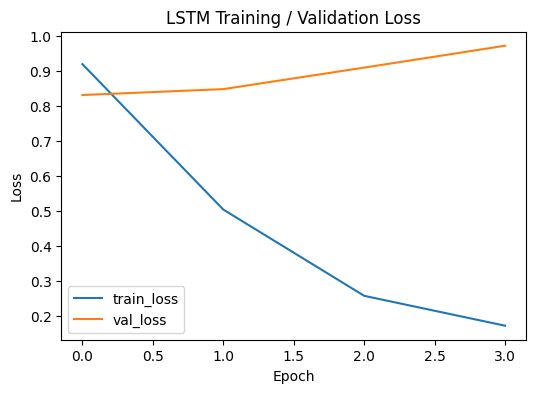

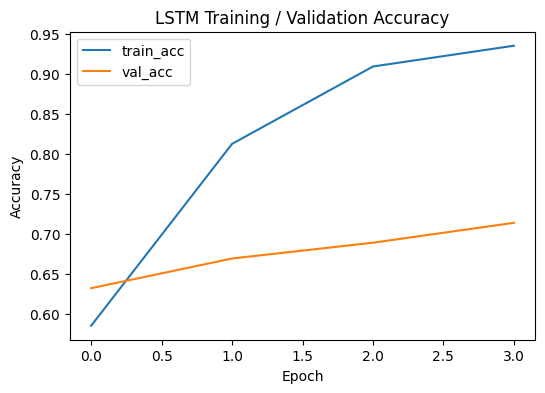

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training / Validation Loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Training / Validation Accuracy')
plt.show()


In [17]:
print("LSTM training configuration:")
print(f"- vocab size: {max_words}")
print(f"- max sequence length: {max_len}")
print(f"- embedding dim: {embedding_dim}")
print(f"- LSTM units: {lstm_units}")
print("- optimizer: Adam, batch size: 128, max epochs: 10, early stopping (patience=3)")


LSTM training configuration:
- vocab size: 20000
- max sequence length: 150
- embedding dim: 256
- LSTM units: 128
- optimizer: Adam, batch size: 128, max epochs: 10, early stopping (patience=3)
